# Import requirements

In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import os
import pdb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict

import torch
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from tqdm import tqdm, trange

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW
)

#new model
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification,

    AutoModelForSequenceClassification,
    AutoTokenizer
)

# 1. Preprocess

In [8]:
def make_id_file(task, tokenizer):
    def make_data_strings(file_name):
        data_strings = []
        with open(os.path.join(file_name), 'r', encoding='utf-8') as f:
            id_file_data = [tokenizer.encode(line.lower()) for line in f.readlines()]
        for item in id_file_data:
            data_strings.append(' '.join([str(k) for k in item]))
        return data_strings
    
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1')
    train_neg = make_data_strings('sentiment.train.0')
    dev_pos = make_data_strings('sentiment.dev.1')
    dev_neg = make_data_strings('sentiment.dev.0')

    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

In [9]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [10]:
from google.colab import files
uploaded = files.upload()

In [11]:
!ls

pytorch_model.bin  sentiment.dev.0  sentiment.train.0
sample_data	   sentiment.dev.1  sentiment.train.1


In [12]:
train_pos, train_neg, dev_pos, dev_neg = make_id_file('yelp', tokenizer)

it will take some times...
make id file finished!


In [13]:
train_pos[:10]

['0 40881 15381 6 5 2',
 '0 133924 43373 4516 6 5 2',
 '0 1836 2843 765 31815 5361 7 136 6 2980 24709 3129 83 6183 4127 6 5 2',
 '0 442 242 7 10 4127 47 11 14437 23233 16857 6 5 2',
 '0 70 23082 83 101786 6 5 2',
 '0 4127 1909 15381 6 5 2',
 '0 4127 4516 6 5 2',
 '0 101084 111 5155 83 44277 2873 136 71358 111 5361 7 6 5 2',
 '0 6782 3687 100 40781 707 1909 69881 7 136 115393 6 5 2',
 '0 70 3525 37457 33342 44613 6 5 2']

In [14]:
train_neg[:10]

['0 17 509 17110 538 121742 19 6 5 2',
 '0 221 98 47 70 23233 124308 6 4 70 111880 83 4537 11675 111 70 48137 6 5 2',
 '0 20187 163 257 136 10 8721 111 7547 107 69819 9993 49036 6 5 2',
 '0 33720 6183 5361 619 959 41965 53 111 70 3650 101 2606 454 27167 7909 6 5 2',
 '0 17932 6 4 70 2288 344 23233 16857 6 4 442 83 10 2955 60744 6 5 2',
 '0 17 1902 47 8783 3650 101 2606 454 47 15190 96967 47 70 23233 16857 6 5 2',
 '0 2412 30745 163 2685 509 10 25534 100 70 184897 98 70 5609 6 5 2',
 '0 621 398 200 59725 163 705 2',
 '0 17 509 959 7730 47 8783 100 70 184897 98 70 5609 6 5 2',
 '0 17 12989 297 442 15490 9993 49036 6 4 168390 6 4 98 17514 6 4 707 184897 6 5 2']

In [15]:
class SentimentDataset(object):
    def __init__(self, tokenizer, pos, neg):
        self.tokenizer = tokenizer
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += [self._cast_to_int(pos_sent.strip().split())]
            self.label += [[1]]
        for neg_sent in neg:
            self.data += [self._cast_to_int(neg_sent.strip().split())]
            self.label += [[0]]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [16]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

In [17]:
for i, item in enumerate(train_dataset):
    print(item)
    if i == 10:
        break

(array([    0, 40881, 15381,     6,     5,     2]), array([1]))
(array([     0, 133924,  43373,   4516,      6,      5,      2]), array([1]))
(array([    0,  1836,  2843,   765, 31815,  5361,     7,   136,     6,
        2980, 24709,  3129,    83,  6183,  4127,     6,     5,     2]), array([1]))
(array([    0,   442,   242,     7,    10,  4127,    47,    11, 14437,
       23233, 16857,     6,     5,     2]), array([1]))
(array([     0,     70,  23082,     83, 101786,      6,      5,      2]), array([1]))
(array([    0,  4127,  1909, 15381,     6,     5,     2]), array([1]))
(array([   0, 4127, 4516,    6,    5,    2]), array([1]))
(array([     0, 101084,    111,   5155,     83,  44277,   2873,    136,
        71358,    111,   5361,      7,      6,      5,      2]), array([1]))
(array([     0,   6782,   3687,    100,  40781,    707,   1909,  69881,
            7,    136, 115393,      6,      5,      2]), array([1]))
(array([    0,    70,  3525, 37457, 33342, 44613,     6,     5,     2])

In [18]:
def collate_fn_style(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)

    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)

    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

In [19]:
train_batch_size=256 #batch size -> 32 to 128
eval_batch_size=128 #batch size -> 64 to 128

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True, collate_fn=collate_fn_style,
                                           pin_memory=True, num_workers=2)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=eval_batch_size,
                                         shuffle=True, collate_fn=collate_fn_style, #shuffle false -> true
                                         num_workers=2)

In [20]:
# random seed
random_seed=42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base')
model.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0): XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tr

In [21]:
model.train()
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

In [23]:
import matplotlib.pyplot as plt
import time
iter_x = []
max_iteration = 0
acc_y = []
loss_y = []

starttime = time.time()

In [24]:
train_epoch = 3
lowest_valid_loss = 9999.
for epoch in range(train_epoch):
    with tqdm(train_loader, unit="batch") as tepoch:
        for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            position_ids = position_ids.to(device)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            # output = model(input_ids=input_ids,
            #                attention_mask=attention_mask,
            #                token_type_ids=token_type_ids,
            #                position_ids=position_ids,
            #                labels=labels)
            output = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        position_ids=position_ids,
                        labels=labels)

            loss = output.loss
            loss.backward()

            optimizer.step()

            tepoch.set_postfix(loss=loss.item())

            #### matplotlib ###
            if max_iteration < iteration:
                max_iteration = iteration
                if epoch>0:
                    assert False
            ### matplotlib ###



            if iteration != 0 and iteration % int(len(train_loader) / 10) == 0:
                # Evaluate the model five times per epoch
                with torch.no_grad():
                    model.eval()
                    valid_losses = []
                    predictions = []
                    target_labels = []
                    for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(dev_loader,
                                                                                                desc='Eval',
                                                                                                position=1,
                                                                                                leave=None):
                        input_ids = input_ids.to(device)
                        attention_mask = attention_mask.to(device)
                        token_type_ids = token_type_ids.to(device)
                        position_ids = position_ids.to(device)
                        labels = labels.to(device, dtype=torch.long)

                        # output = model(input_ids=input_ids,
                        #                attention_mask=attention_mask,
                        #                token_type_ids=token_type_ids,
                        #                position_ids=position_ids,
                        #                labels=labels)
                        output = model(input_ids=input_ids,
                                        attention_mask=attention_mask,
                                        token_type_ids=token_type_ids,
                                        position_ids=position_ids,
                                        labels=labels)

                        logits = output.logits
                        loss = output.loss
                        valid_losses.append(loss.item())

                        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                        batch_labels = [int(example) for example in labels]

                        predictions += batch_predictions
                        target_labels += batch_labels

                acc = compute_acc(predictions, target_labels)
                valid_loss = sum(valid_losses) / len(valid_losses)

                ### matplotlib start ###
                
                iter_x.append(iteration)
                acc_y.append(acc)
                loss_y.append(valid_loss)
                
                ### matplotlib end ###


                if lowest_valid_loss > valid_loss:
                    print('Acc for model which have lower valid loss: ', acc)
                    torch.save(model.state_dict(), "./pytorch_model.bin")
                    lowest_valid_loss = valid_loss

Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.76it/s]
                                                     

Acc for model which have lower valid loss:  0.5025


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.82it/s]
                                                     

Acc for model which have lower valid loss:  0.79075


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.94it/s]
                                                     

Acc for model which have lower valid loss:  0.92525


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.52it/s]
                                                     

Acc for model which have lower valid loss:  0.95975


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.90it/s]
                                                     

Acc for model which have lower valid loss:  0.96275


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.84it/s]
                                                     

Acc for model which have lower valid loss:  0.961


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.74it/s]
                                                     

Acc for model which have lower valid loss:  0.968


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.88it/s]
                                                     

Acc for model which have lower valid loss:  0.97175


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.63it/s]
                                                     

Acc for model which have lower valid loss:  0.97375


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.94it/s]
                                                     

Acc for model which have lower valid loss:  0.97375


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.89it/s]
                                                     

Acc for model which have lower valid loss:  0.974


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.82it/s]
                                                     

Acc for model which have lower valid loss:  0.97875


Eval:  97%|█████████▋| 31/32 [00:05<00:00,  5.73it/s]
                                                     

Acc for model which have lower valid loss:  0.97725


Epoch 2: 100%|██████████| 1732/1732 [30:35<00:00,  1.06s/batch, loss=0.0339]


In [25]:
endtime = time.time()

In [26]:
import pandas as pd
test_df = pd.read_csv('test_no_label.csv')

FileNotFoundError: ignored

In [ ]:
test_dataset = test_df['Id']

In [ ]:
def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

In [ ]:
test = make_id_file_test(tokenizer, test_dataset)

In [ ]:
test[:10]

In [ ]:
class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

In [ ]:
test_dataset = SentimentTestDataset(tokenizer, test)

In [ ]:
def collate_fn_style_test(samples):
    input_ids = samples
    max_len = max(len(input_id) for input_id in input_ids)

    #sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1] #bug
    sorted_indices = [i for i in range(len(input_ids))]
    
    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids

In [ ]:
test_batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,
                                          shuffle=False, collate_fn=collate_fn_style_test,
                                          num_workers=2)

In [ ]:
with torch.no_grad():
    model.eval()
    predictions = []
    for input_ids, attention_mask, token_type_ids, position_ids in tqdm(test_loader,
                                                                        desc='Test',
                                                                        position=1,
                                                                        leave=None):

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        position_ids = position_ids.to(device)

        # output = model(input_ids=input_ids,
        #                attention_mask=attention_mask,
        #                token_type_ids=token_type_ids,
        #                position_ids=position_ids)
        output = model(input_ids=input_ids,
                      attention_mask=attention_mask,
                      token_type_ids=token_type_ids,
                      position_ids=position_ids)

        logits = output.logits
        print(logits)
        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
        predictions += batch_predictions

In [ ]:
test_df['Category'] = predictions

In [ ]:
test_df.to_csv('submission_roberta_base_uncased.csv', index=False)

In [ ]:
print(lowest_valid_loss)

In [27]:
print(iter_x)
print(acc_y)
print(loss_y)
print(max_iteration)
iter_x_save = iter_x

[173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730]
[0.5025, 0.79075, 0.92525, 0.95975, 0.96275, 0.961, 0.9575, 0.968, 0.97175, 0.97375, 0.97375, 0.973, 0.974, 0.96825, 0.9665, 0.967, 0.97325, 0.97375, 0.974, 0.97275, 0.97875, 0.974, 0.978, 0.9755, 0.97475, 0.97725, 0.9785, 0.9785, 0.97625, 0.974]
[0.7083671111613512, 0.4586925134062767, 0.19822125509381294, 0.10906180599704385, 0.10156854544766247, 0.09893225535051897, 0.11212278588209301, 0.07784445426659659, 0.07243697682861239, 0.07002411322901025, 0.07287658999484847, 0.08077664638403803, 0.07133354127290659, 0.0765679832547903, 0.083498041407438, 0.0841555196675472, 0.0706927835708484, 0.06601442204555497, 0.06556325306883082, 0.06985731341410428, 0.06329255769378506, 0.08012783376034349, 0.06332585454219952, 0.07312980297137983, 0.07027435302734375, 0.059720281133195385, 0.0602998077229131, 0.06393887661397457, 0.068

In [28]:
cnt = 0
for i in range(len(iter_x)):
    if cnt >= iter_x[i]:
        iter_x[i] = max_iteration + iter_x[i]
    cnt = iter_x[i]
cnt = 0
for i in range(len(iter_x)):
    if cnt >= iter_x[i]:
        iter_x[i] = max_iteration + iter_x[i]
    cnt = iter_x[i]
print(iter_x)

[173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 1904, 2077, 2250, 2423, 2596, 2769, 2942, 3115, 3288, 3461, 3635, 3808, 3981, 4154, 4327, 4500, 4673, 4846, 5019, 5192]


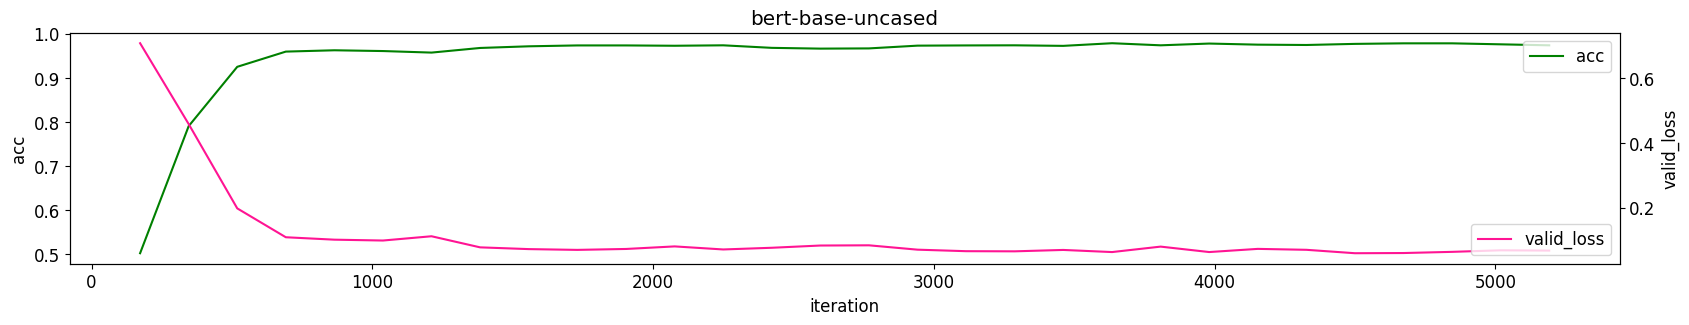

In [29]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (20, 3)
plt.rcParams['font.size'] = 12

x = iter_x
y1 = acc_y
y2 = loss_y

fig, ax1 = plt.subplots()
ax1.set_xlabel('iteration')
ax1.set_ylabel('acc')
ax1.plot(x, y1, color='green',label='acc')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.set_ylabel('valid_loss')
ax2.plot(x, y2, color='deeppink',label='valid_loss')
ax2.legend(loc='lower right')

plt.title("bert-base-uncased")

plt.show()

In [30]:
print(endtime - starttime)

5511.347711324692
